In [5]:
import cftime
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import pandas as pd
from scipy import interpolate

%matplotlib widget

In [4]:
def bathy_along_track(bathy_file:str, xFRF:np.ndarray, yFRF:np.ndarray,
                      single_trajectory=False):
    """
    Linearly interpolates the bathymetry along the track of
    the microSWIFT.

    Parameters
    ----------
    bathy_file : str
        url or path to bathy bathymetry file
    xFRF : np.ndarray
        1D or 2D array of microSWIFT xFRF locations
    yFRF : np.ndarray
        1D or 2D array of microSWIFT xFRF locations
    single_trajectory : boolean
        True or False if plotting a single trajectory

    Returns
    -------
    bathy_along_track : np.ndarray
        1D or 2D array of bottom elevation at each location along the track

    """
    if single_trajectory is True:
        xFRF = xFRF.reshape(1,xFRF.size)
        yFRF = yFRF.reshape(1,yFRF.size)
    else:
        pass
    
    # Create bathymetry interpolating function from 2D grid
    bathy_dataset = nc.Dataset(bathy_file)
    x = bathy_dataset['xFRF'][:]
    y = bathy_dataset['yFRF'][:]
    z = bathy_dataset['elevation'][0,:,:]
    bathy_f = interpolate.RegularGridInterpolator((x, y), np.transpose(z), 
                                                  method='linear', bounds_error=False)

    bathy_along_track = np.empty(xFRF.shape)
    for trajectory in range(xFRF.shape[0]):
        for n in np.arange(xFRF.shape[1]):
            point = np.array([xFRF[trajectory, n],
                              yFRF[trajectory, n]])
            bathy_along_track[trajectory, n] = np.squeeze(bathy_f(point).item())

    return np.array(bathy_along_track)

20161
20161
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True


/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_70981/938195464.py:41: UserWarning: Warning: converting a masked element to nan.
  point = np.array([xFRF[trajectory, n],


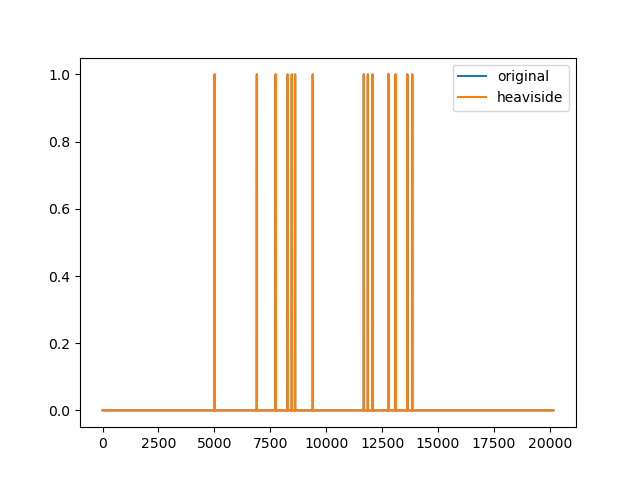

In [14]:
# Load an actual mission trajectory and check how well the averaging does
mission_nc = '../../data/mission_19.nc'
mission_dataset = nc.Dataset(mission_nc, mode='r')

# Extract the x and y locations of each buoy in the FRF coordinate system
x_locations = np.ma.masked_invalid(mission_dataset['xFRF'])
y_locations = np.ma.masked_invalid(mission_dataset['yFRF'])
mission_num = 19
trajectory_num = 5
x_vals = x_locations[trajectory_num, :]

# Get the time values of the mission
time = cftime.num2pydate(mission_dataset['time'],
                            units=mission_dataset['time'].units,
                            calendar=mission_dataset['time'].calendar)

# Compute the gradient and apply the moving average smoothing
cross_shore_vel = np.gradient((x_vals[0] - x_vals), 1/12)
cross_shore_vel = np.ma.filled(cross_shore_vel, np.NaN)

# Find phase speed along the track
mission_df = pd.read_csv('../../data/mission_df.csv').sort_values(by=['mission number'])
water_level = mission_df[mission_df['mission number'] == mission_num]['water level [m]'].values[0]
trajectory_bathy = bathy_along_track(bathy_file='../../data/FRF_geomorphology_DEMs_surveyDEM_20211021.nc', 
                                                                xFRF=x_locations[trajectory_num, :], 
                                                                yFRF=y_locations[trajectory_num, :],
                                                                single_trajectory=True)[0]
trajectory_depth = trajectory_bathy + water_level

# Compute Linear Phase Speed at each point in track
phase_speed_along_track = np.sqrt(np.abs(trajectory_depth * 9.8))

# Threshold Speed along the track
speed_threshold = 0.3
jump_threshold = phase_speed_along_track * speed_threshold 
jump_times_heaviside = np.heaviside((cross_shore_vel - jump_threshold), 1)
jump_times_heaviside[np.isnan(jump_times_heaviside)] = 0

# Jump times 
jump_times = np.zeros(cross_shore_vel.size)
jump_inds = np.where(cross_shore_vel >= jump_threshold)
jump_times[jump_inds] = 1

# check if the heaviside output is the same as the jump times code
print(jump_times.size)
print(jump_times_heaviside.size)
print(jump_times[-10:])
print(jump_times_heaviside[-10:])
print(np.array_equal(jump_times, jump_times_heaviside))

# Plot the output of the two arrays
fig, ax = plt.subplots()
ax.plot(jump_times, label='original')
ax.plot(jump_times_heaviside, label='heaviside')
ax.legend()

This method is the exact same that I was using before but to stay consistent with Eeltinks work we will use the heaviside function